* Notes
* Date: 10/03/2021
* Contents: train a multi-class LC-MIL model on 5 pilot WSIs of osteosarcoma (leave 1 for validation). Then infer all 6 WSIs.
* Setting:
    - MIX patch: firstly mix all patches from 5 slides, and then pack bags
    - Magnification: 10x magnification
    - Training parameters:
    - weight decay: 10e-4
    - initial learning rate: 0.00005
    - weight decay to 0.2 every 100 bags

In [16]:
key = 'mixpatch_10x_w4'

### Check Inference results

In [13]:
import matplotlib.cm as cm
import openslide
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from skimage import morphology
from auxillary import *

def show_annotations(slide_ob, annot, unit, drawing_parameters,s=0.5,fontsize=10):
    thumbnail = slide_ob.get_thumbnail((slide_ob.dimensions[0]//unit,slide_ob.dimensions[1]//unit))
    f, ax = plt.subplots(1,1,figsize=(5,5))
    ax.imshow(thumbnail)
    for label in drawing_parameters:     
        for region in annot[label]['outer']:
            x = [i[0]/unit for i in region]
            y = [i[1]/unit for i in region]
            if region == annot[label]['outer'][0]:
                ax.scatter(x,y,c = drawing_parameters[label]['color'], label = drawing_parameters[label]['legend'],s=s)
            else:
                ax.scatter(x,y,c = drawing_parameters[label]['color'],s=s)    
    for region in annot[label]['inner']:
            x = [i[0]/unit for i in region]
            y = [i[1]/unit for i in region]
            if region == annot[label]['inner'][0]:
                ax.scatter(x,y,c = drawing_parameters[label]['color'], label = drawing_parameters[label]['legend'],s=s)
            else:
                ax.scatter(x,y,c = drawing_parameters[label]['color'],s=s)   
    ax.legend(fontsize=fontsize)
    ax.set_axis_off()  
    
def measure_ratio(heatmap, channels = ['necrosis','non-tumor','viable']):
    M = {}
    mask_predicted_1 = np.zeros((heatmap.shape[0],heatmap.shape[1]))
    mask_predicted_1[:] = np.nan
    mask_predicted = np.argmax(heatmap,axis=2)
    mask_predicted_1[heatmap[:,:,0]>0] = mask_predicted[heatmap[:,:,0]>0]
    for i in range(len(channels)):
        M[channels[i]] = np.nansum(mask_predicted_1==i)/np.sum(heatmap[:,:,i]>=0)*100
    return M

In [14]:
estimate={
    '16714495':{},'16714498':{},'16714499':{},'16714503':{},'16714505':{},'16714507':{}
}
estimate['16714495']['pathologist'] = 99
estimate['16714498']['pathologist'] = 97
estimate['16714499']['pathologist'] = 5
estimate['16714503']['pathologist'] = 65
estimate['16714505']['pathologist'] = 20
estimate['16714507']['pathologist'] = 45


 16714495
Necrosis/tumor: 96.894%

 16714498
Necrosis/tumor: 94.454%

 16714499
Necrosis/tumor: 61.654%

 16714503
Necrosis/tumor: 60.317%

 16714505
Necrosis/tumor: 33.952%

 16714507
Necrosis/tumor: 58.276%


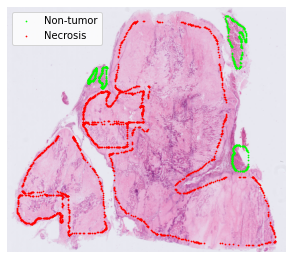

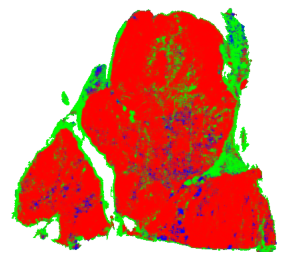

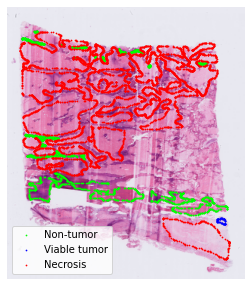

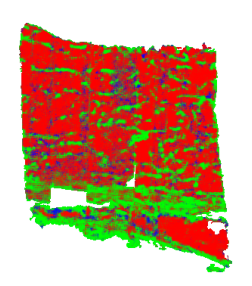

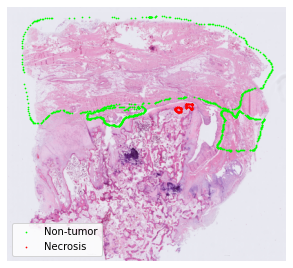

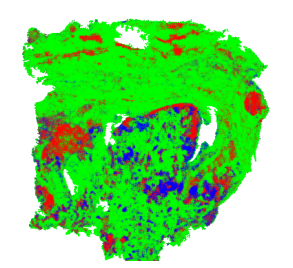

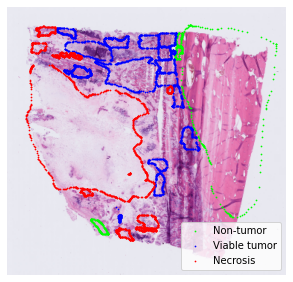

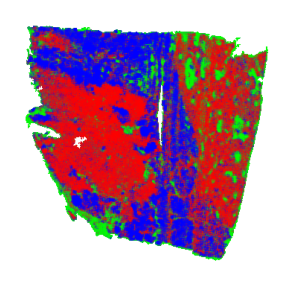

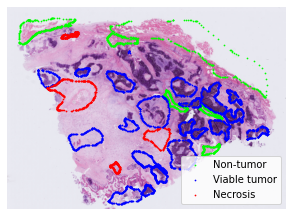

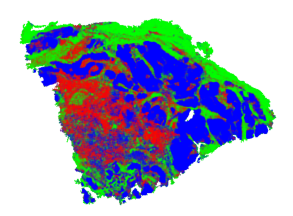

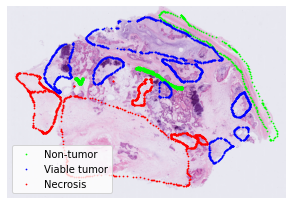

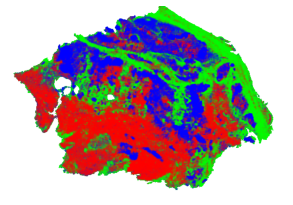

In [17]:
unit =  256
for slide_ID in ['16714495','16714498','16714499','16714503','16714505','16714507']: # '16714495','16714498','16714499','16714503','16714505','16714507'
    print('\n',slide_ID)
    # read slides
    slide_ob = openslide.OpenSlide('/cis/net/gaon1/data/zwang/Aaron/'+slide_ID+'.ndpi')
    # read annotations
    annots_coarse =  read_Aaron_annotations('/cis/net/gaon1/data/zwang/Aaron/'+slide_ID+'.xml')
    # read heatmaps
    heatmap_stroma = np.load('/cis/home/zwang/Data/ComNecrosis/Aaron/'+slide_ID+'/aggregate/heatmap_stroma_'+key+'.npy')
    heatmap_necrosis = np.load('/cis/home/zwang/Data/ComNecrosis/Aaron/'+slide_ID+'/aggregate/heatmap_necrosis_'+key+'.npy')
    heatmap_viable = np.load('/cis/home/zwang/Data/ComNecrosis/Aaron/'+slide_ID+'/aggregate/heatmap_viable_'+key+'.npy')
    # show coarse annotations
    drawing_parameters = {'stroma':{'color':'lime', 'legend':'Non-tumor'},
                         'viable':{'color':'blue', 'legend':'Viable tumor'},
                         'necrosis':{'color':'red', 'legend':'Necrosis'}}
    show_annotations(slide_ob, annots_coarse, unit,drawing_parameters)
    # stack heatmaps
    heatmap_stack = np.stack((heatmap_necrosis,heatmap_stroma,heatmap_viable),axis=2)
    heatmap_stack_show = np.zeros_like(heatmap_stack,dtype=float)
    heatmap_stack_show[:] = 1
    heatmap_stack_show[heatmap_stack>0]= heatmap_stack[heatmap_stack>0]
    f, ax = plt.subplots(1,1,figsize=(5,5))
    plt.imshow(heatmap_stack_show)
    ax.set_axis_off()  
    

    M = measure_ratio(heatmap_stack, channels = ['necrosis','non-tumor','viable'])
    print('Necrosis/tumor: {:.3f}%'.format(100*M['necrosis']/(M['necrosis']+M['viable'])))
    estimate[slide_ID][key] = 100*M['necrosis']/(M['necrosis']+M['viable'])

In [18]:
def dict2df(estimate):
    df = pd.DataFrame({})
    index = 0
    for slide_ID in estimate.keys():
        for version in estimate[slide_ID].keys():
            df.loc[index, 'slide_ID'] = slide_ID
            df.loc[index, version] = estimate[slide_ID][version]/100
        index +=1    
    return df
df = dict2df(estimate)

[Text(0.5, 0, 'slide ID'),
 Text(0, 0.5, 'Necrosis/tumor'),
 Text(0.5, 1.0, 'mixpatch_10x_w4 except 16714499')]

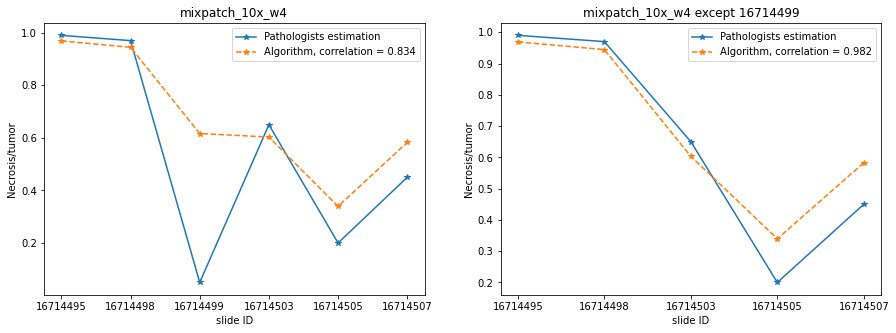

In [19]:
f, ax  = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(df['slide_ID'],df['pathologist'],'-*',label = 'Pathologists estimation',)
ax[0].plot(df['slide_ID'],df[key],'--*',
         label = 'Algorithm, correlation = {:.3f}'.format(df.corr().loc['pathologist',key]))
ax[0].legend()
ax[0].set(xlabel = 'slide ID', ylabel = "Necrosis/tumor", title = key)

df =  df.loc[df.slide_ID != '16714499']
ax[1].plot(df['slide_ID'],df['pathologist'],'-*',label = 'Pathologists estimation',)
ax[1].plot(df['slide_ID'],df[key],'--*',
         label = 'Algorithm, correlation = {:.3f}'.format(df.corr().loc['pathologist',key]))
ax[1].legend()
ax[1].set(xlabel = 'slide ID', ylabel = "Necrosis/tumor", title = key+' except 16714499')